<a href="https://colab.research.google.com/github/victor-armegioiu/Learning-Bayesian-Priors/blob/main/Prior_as_Particles_(Standard_Variational_Inference_for_posterior_training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Better priors represented as particles

---

Seed papers: FUNCTIONAL VARIATIONAL BAYESIAN NEURAL NETWORKS (https://arxiv.org/pdf/1903.05779.pdf)

Understanding Variational Inference in Function-Space (https://arxiv.org/pdf/2011.09421.pdf)



## Setup 

Necessary imports, setting up the Colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# gpflow doesn't come preloaded with colab.
!pip3 install gpflow

In [ ]:
import numpy as np
import time

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt

from gdrive.MyDrive.prior_learning.spectral_stein_grad.estimator import SpectralScoreEstimator
from gdrive.MyDrive.prior_learning import data_utils
from gdrive.MyDrive.prior_learning import gp_utils
from gdrive.MyDrive.prior_learning import prior_utils
from gdrive.MyDrive.prior_learning import sliced_score_estimation

tf.compat.v1.enable_eager_execution()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.executing_eagerly()

True

In [ ]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Building the dataset

We assume a typical meta-learning scenario, where one has access to a limited number of related tasks which are assumed to be generated under the same generating process. Naturally, we expect the underlying generating parameters of each task to be subject to small perturbations, rendering a family of functions. 
Specifically, we assume access to a \textit{meta-training} dataset $\mathcal{D}_{\text{train}} := \{T_i\}_{i=1}^m$ where each task $T_i := \{(x_j, y_j)\}_{j=1}^k$ corresponds to a meta-learning task.
Analogously, we assume access to a \textit{meta-tuning} dataset $\mathcal{D}_{\text{tune}} := \{T_i\}_{i=1}^n$, where typically $n \ll m$. \\


In this example, we generate the index sets per task as $X_i \sim \mathcal{U}(-5, 5)$ and apply a linear combination of a scaled + shifted sinusoid and an affine transform to get the targets $y_i$.

In [ ]:
config = {
    'generation_method': 'sine', 
    'meta_training_task_cnt': 50,   # Meta tasks used for prior learning.
    'meta_tuning_task_cnt': 25,     # Meta tasks to deploy learned priors on.
    'task_size': 5, # Number of inputs/outputs per meta-task.
    'input_shape': (1,),
}

In [ ]:
meta_training_tasks, meta_tuning_tasks = data_utils.GetDataset(config)

In [ ]:
def NormalizeData(tasks, scaler=None, y_max=None):
  if not scaler or not y_max:
    scaler = StandardScaler()
    y_max = np.max([np.max(y) for _, y in tasks])
  for x, y in tasks:
    x = scaler.fit_transform(x)
    y /= y_max
  return tasks, scaler, y_max

Use last `test_tasks_cnt` for testing, and leave the rest for training. 

In [ ]:
test_tasks_cnt = 5

In [ ]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
meta_tuning_train_tasks, scaler, y_max = NormalizeData(
    meta_tuning_tasks[:-test_tasks_cnt])
meta_tuning_test_tasks, _ , _ = NormalizeData(meta_tuning_tasks[-test_tasks_cnt:],
                                       scaler, y_max)

In [ ]:
# Scale meta_training_tasks as well.
meta_training_tasks, _, _ = NormalizeData(meta_training_tasks)

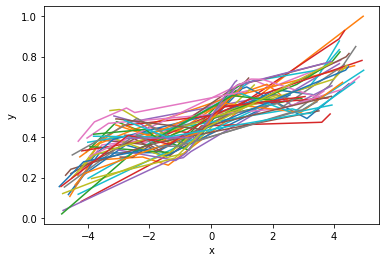

In [ ]:
for x, y in meta_training_tasks:
  plt.plot(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

## GP Prior Setup

Train a $\mathcal{GP}$ on the training data, so that we may later use the tuned kernel for estimating the covariance of a Normal distribution over function values (this shall be used as the prior in the `f-bnn` formulation below).

In [ ]:
# Pre-train GP prior.
mean_function, kernel = gp_utils.TrainGPPrior(meta_training_tasks, verbose=True)


Currently in meta-iteration/epoch 1/5:
Task 0 log-likelihood: -5.254992507854491
Task 5 log-likelihood: -3.9980017087042534
Task 10 log-likelihood: -3.7490316570636177
Task 15 log-likelihood: -3.3792788985375135
Task 20 log-likelihood: -2.6489726642593823
Task 25 log-likelihood: -2.358396618506363
Task 30 log-likelihood: -2.2543869299557477
Task 35 log-likelihood: -0.9125043520627187
Task 40 log-likelihood: -2.2597796798360585
Task 45 log-likelihood: -0.6056557110791179

Currently in meta-iteration/epoch 2/5:
Task 0 log-likelihood: -3.653880602651848
Task 5 log-likelihood: -3.2868128192418773
Task 10 log-likelihood: -3.1223493212469977
Task 15 log-likelihood: -2.7189708198204627
Task 20 log-likelihood: -2.0552213511724573
Task 25 log-likelihood: -1.8482464737442816
Task 30 log-likelihood: -1.691210499992199
Task 35 log-likelihood: -0.523222829096512
Task 40 log-likelihood: -1.7781101718798347
Task 45 log-likelihood: -0.2989843463238433

Currently in meta-iteration/epoch 3/5:
Task 0 lo

## Sliced Score Estimator Setup (https://arxiv.org/pdf/1905.07088.pdf)

Here we train a network $h(\cdot, \hat{\theta})$ which minimizes the objective $\mathbb{E}_{x \sim \mu} \Vert h(x, \hat{\theta}) - \nabla_x \log p(x) \Vert_{2}$ in an unsupervised way, where $\mu$ is some unknown data generating process and $p := \sum_i \delta_{x_i}$ is an empirical measure represented as a set of particles.

In [ ]:
input_shape = (1,)
score_net = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, name='input'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(input_shape[0]),
])

# Take all meta-functions as an empirical prior over functions.
data = np.concatenate(tuple((y for _, y in meta_training_tasks)))
config_slice_train = {'data': data,
          'score_net': score_net,
          'epochs': 10, 
          'lambda_reg': 0.15
}

In [ ]:
score_net, best_loss = (
    sliced_score_estimation.GetSlicedScoreEstimator(config_slice_train,
                                                    verbose=True))

Epoch [0], loss: [66.190899]


## Model setup

This section covers the actual training of our particle based models, minimizing the `f-bnn` loss (likelihood term + $KL$ term), where we represent the prior as a set of particles. The prior particles themselves will be the actual **training targets**, since we regard them to be representative of the true generating process.

In [ ]:
def ApproximateEntropyGrads(estimator, samples):
  dlog_q = estimator.compute_gradients(samples)
  surrogate = tf.reduce_mean(
      tf.reduce_sum(
          tf.stop_gradient(-dlog_q) * tf.cast(samples, tf.float64), -1))
  return surrogate

In [ ]:
# Estimator to be used for computing score gradients of implicit distributions
# represtend as sets of particles.
estimator = SpectralScoreEstimator(n_eigen_threshold=0.99, eta=0.0)

In [ ]:
# TODO: Allow for customizable models.
def _GetModel(meta_task_size=((1,), 5)):
  kl_divergence_function = (lambda q, p, _:
                            tfp.distributions.kl_divergence(q, p) /
                            tf.cast(meta_task_size[1], dtype=tf.float64))

  # Setup a feed forward BNN with 1 hidden layer.
  model = tf.keras.Sequential([
      tf.keras.Input(shape=meta_task_size[0],name='input'),
      tfp.layers.DenseFlipout(10, kernel_divergence_fn=kl_divergence_function,
                              activation=tf.nn.relu, name="dense_tfp_1"),
      tfp.layers.DenseFlipout(1,
                              kernel_divergence_fn=kl_divergence_function,
                              name="out_tfp_pred"),
  ])

  return model

Reframing variational inference in the function space, we arrive at the following objective formulation [Sun et al., 2019]

\begin{equation}
 \log p(\mathcal{D} \vert f) - \lambda KL(q \Vert p) \hspace{0.5cm}(1)
\end{equation}

where $q, p$ represent the posterior, and the prior over function values.

Using the reparametrization trick, function values $f(x) \sim q(\cdot)$ are drawn from a parameterized neural net $g_\phi(x ; \xi)$. Here $\phi$ denotes the set of optimizable parameters, while $\xi$ is a random perturbation under which the change of variable is performed. Hence, drawing samples $f(x) \sim q$ is done by forwarding $x$ through $g_\phi(\cdot ; \xi)$.

In order to obtain a feasible optimization procedure from $(1)$, the $KL$ divergence gradient is then expanded as 

\begin{equation}
 \nabla_\phi KL(q \Vert p)  = \mathbb{E}_{\xi}[\nabla_\phi \textbf{f} (\nabla_\textbf{f} \log q(\textbf{f}) - \nabla_\textbf{f}\log p(\textbf{f})  )] \hspace{0.5cm}(2)
\end{equation}

Note that the $KL$ term is made tractable by using SSGE [Shi et al., 2018] to extract gradients for the score functions, since both $q(\cdot), p(\cdot)$ are both implicit distributions represented as particles.

In [ ]:
# Draw samples from the variational posterior.
def SamplePosterior(variational_posterior, n_particles, x, training=False):
  return tf.stack([variational_posterior(x, training=training)  
                    for _ in range(n_particles)])

In [ ]:
def Train(model=_GetModel(),
          train_tasks=None,
          test_tasks=None,
          epochs=10,
          n_particles=10,
          task_size=5,
          prior_particles=None,
          use_functional_kl=True,
          lambda_kl=1.0,
          method='sliced_score_estimation',
          config=None,
          verbose=True):

  """
  Utility function used to train a model to minimize the f-BNN loss.

  @params:
    -train_tasks: [(X_train_i, y_train_i)], list of pairs where X_train_i,
      is the i-th meta-tuning input task and y_train_i the function values.
    -test_tasks: same as |train_tasks|, only a smaller dataset of related tasks
      used for testing.
    -epochs: number of meta-iterations/epochs to train on the given tasks.   
    -task_size: number of samples per task.
    -n_particles: number of function values to draw from the variational 
      posterior at every input location (i.e. task); this will be used as the
      empirical posterior over functions.
    -prior_particles: particles (samples) to represent the true prior.
    -use_functional_kl: if this is set to |True| the whole fELBO objective 
      is used for training - otherwise, we just do MLE and drop the prior term.
    -lamba_kl: weight of the KL divergence term.
    -method: method to be used for approximating log-prior gradients in case
      the prior is represented as a set of particles.
    -config: dictionary used to serialize some particular requirements needed
      for calling the |prior_utils.ComputeCrossEntropy| utility function used
      for computing the functional KL gradients.
    -verbose: if this is set to |True| it prints relevant statistics concerning
      the training progress.

  @returns:
    model: post-training variational posterior neural net.
    test_losses: list containing losses recorded on the test set.
  """
  mse = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(0.001)
  test_losses = [] # Record losses we see during testing.

  if use_functional_kl:
    print('Using %s for computing log-prior gradients. \n' % method)

  for epoch in range(epochs):
    for i, (X_train, y_train) in enumerate(train_tasks): 
      with tf.GradientTape() as g:
        predictions = SamplePosterior(model, n_particles, X_train, True)
        log_likelihood = -mse(tf.reduce_mean(predictions, axis=0), y_train)
        
        if use_functional_kl:
            # Use SSGE to approximate the log gradients of the functional
            # posterior given the 'drawn' samples from the neural net.
            # See Equation (2).
            posterior_samples = (
                predictions + np.random.normal(0, 1, size=predictions.shape))
            entropy_sur = ApproximateEntropyGrads(estimator, posterior_samples)
          
            if 'gp' in method:
              config['x'] = X_train
              config['y'] = tf.squeeze(posterior_samples, axis=2)
            elif 'ssge' in method:
              config['y'] = posterior_samples
            elif 'score' in method:
              config['y'] = tf.reshape(posterior_samples,
                  [n_particles *  len(y_train), -1])
              
            cross_entropy_sur = prior_utils.ComputeCrossEntropy(configs[method])
            
            # Add these up to produce the KL term to be optimized.
            functional_kl = (tf.cast(entropy_sur, tf.float32) -
                              tf.cast(cross_entropy_sur, tf.float32))
            log_likelihood += (lambda_kl * tf.cast(functional_kl, tf.float64) /
                              len(X_train))
      
        grads = g.gradient(-log_likelihood, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if verbose and epoch % 2 == 0 and i == (len(train_tasks) - 1):
      test_log_likelihoods = []

      for X_test, y_test in test_tasks:
        test_predictions = SamplePosterior(model, n_particles, X_test, False)
        test_log_likelihood = -mse(tf.reduce_mean(predictions, axis=0), 
                                        y_test)
        test_log_likelihoods.append(test_log_likelihood.numpy())
        print('Epoch [%d] test log-likelihood: [%f]' % 
              (epoch, test_log_likelihood,))
        test_losses.append(np.mean(test_log_likelihoods))
      
  return (model, test_losses)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


## Results

We run the models in two regimes:



1.   Just use $MLE$ for training, no functional $KL$.
2.   Use the full `f-bnn` objective (Eq. (1)), where we perform the log-prior gradient estimation with each of : `Sliced Score Estimation`, `GP Prior`, `Spectral Stein Gradient Estimator`.

We run the training loop `tries_per_method` times for each of the 4 above combinations.



In [ ]:
from collections import defaultdict

statistics = defaultdict(list)
tries_per_method = 3
n_particles = 10
prior_particles = np.concatenate(tuple((y for _, y in meta_training_tasks)))
prior_particles = np.squeeze(prior_particles, -1)
  
# Configs used as arguments for the `ComputeCrossEntropy` function, which
# will be used for computing the log_prior gradients
# (or approximate gradients). The method field indicates which log-prior
# gradient scheme we will use. Only 'gp' comes with an analytical form.
# for the gradients, trading off expresiveness.
configs = {
  'gp': {'method': 'gp',
         'kernel_function': kernel,
         'mean_function': mean_function},

  'ssge': {'method': 'ssge',
           'estimator': estimator,
           'n_particles': n_particles,
           'prior_particles': prior_particles},

  'sliced_score_estimation': {
      'method': 'sliced', 
    'score_estimator': score_net},

  'mle' : {},
}

for method in [(False, 'mle'), (True, 'sliced_score_estimation'),
               (True, 'ssge'), (True, 'gp')][::-1]:
  for i in range(tries_per_method):
    print(method, i)
    model, test_losses = Train(
        train_tasks=meta_tuning_train_tasks,
        test_tasks=meta_tuning_test_tasks,
        n_particles=n_particles,
        prior_particles=prior_particles,
        use_functional_kl=method[0],
        method=method[1],
        config=configs[method[1]],
        verbose=True)
    
    statistics[method].append(test_losses[-1])

(True, 'gp') 0
Using gp for computing log-prior gradients. 

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Epoch [0] test log-likelihood: [-0.277336]
Epoch [0] test log-likelihood: [-0.388315]
Epoch [0] test log-likelihood: [-0.305079]
Epoch [0] test log-likelihood: [-0.330250]
Epoch [0] test log-likelihood: [-0.527608]
Epoch [2] test log-likelihood: [-0.216669]
Epoch [2] test log-likelihood: [-0.318158]
Epoch [2] test log-likelihood: [-0.242236]
Epoch [2] test log-likelihood: [-0.261955]
Epoch [2] test log-likelihood: [-0.444963]
Epoch [4] test log-likelihood: [-0.165321]
Epoch [4] test log-likelihood: [-0.253671]
Epoch [4] test log-likelihood: [-0.186518]
Epoch [4] test log-likelihood: [-0.205245]
Epoch [4] test log-likelihood: [-0.367441]
Epoch [6] test log-likelihood: [-0.133088]
Epoch [6] test log-likeliho

In [ ]:
# Show confidence intervals for all results corresponding to each method.
import scipy.stats as st

for method, results in statistics.items():
  print(method[1], ': ', st.t.interval(0.95, len(results) - 1,
                                 loc=np.mean(results), scale=st.sem(results)))

gp :  (-0.24746061441143669, 0.08171181953788116)
ssge :  (-0.038356504123409185, -0.020513906299074902)
sliced_score_estimation :  (-4.959496584458744, 1.8747533996140913)
mle :  (-1.334995230720825, 0.7672888367115329)
